# Home Assignment No. 1


To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* You have to write **CODE** directly inside specified places marked by comments: **BEGIN/END Solution**. Do not create new cells.

* In some problems you are asked to provide a short discussion of the results. For that find the specific place marked via **Your text answer: \<write your answer\>**.

* For every separate problem or subproblem (if specified) you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task.

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e., if the reviewer decides to restart the notebook and run all cells, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest fixing random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include necessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.


## Task 1 - MNIST, kMNIST component analysis and manifold learning. (4 pts.)

### Task 1.1. (1 pt)

Download `MNIST` dataset. Here we will estimate the data intrinsic dimensionality, decompose the dataset on principle components and estimate the cumulative explained variance by each component.

You can either use the [proposed method](https://www.stat.berkeley.edu/~bickel/mldim.pdf) for the estimation of sample intrinsic dimension or any other method (convenient for you). For the first case, yoyu may use the code from [here](https://gist.github.com/mehdidc/8a0bb21a31c43b0cbbdd31d75929b5e4)

1. Estimate the intrinsic dimensionality of the dataset. Provide the plot.
2. Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with **6** different set of components and corresponding explained variance. You can choose any digit from the dataset.

In [1]:
#linear algebra
import numpy as np
#data structures
import pandas as pd
#ml models
import scipy as sp
import sklearn
#plots
import matplotlib.pyplot as plt
%matplotlib inline
#beautiful plots
import seaborn as sns
import statsmodels.api as sm
#off the warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

dg = datasets.load_digits()

scaler = StandardScaler().fit(dg.data)

data = scaler.transform(dg.data)

1) Estimate the intrinsic dimentionality of the dataset. Provide the plot.

(40, 68)


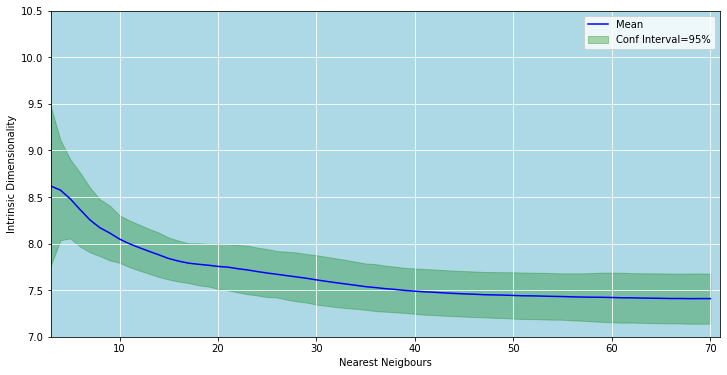

In [3]:
### BEGIN SOLUTION (do not delete this comment!)
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X) # distances between the samples and points
    dist = dist[:, 1:] # the distance between the first points to first points (as basis ) equals zero
    # the first non trivial point
    dist = dist[:, 0:k]# including points k-1
    assert dist.shape == (X.shape[0], k) # requirments are there is no equal points
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1]) # dinstance betveen the bayeasan statistics
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1): # in order to reduse the noise by eliminating of the nearest neibours 
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap': # and each point we want to resample with repeating points to reduse the errors 
            #232 111 133 
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    print(np.array(results).shape)
    return results

######

np.random.seed(2)
warnings.filterwarnings("ignore")

k1 = 3
k2 = 70 
iterations = 40 

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data, 
                             mode='bootstrap', 
                             nb_iter=iterations,
                             k1=k1, k2=k2)

intdim_k_repeated = np.array(intdim_k_repeated)

x = np.arange(k1, k2+1)

plt.figure(figsize=(12, 6))
plt.plot(x, np.mean(intdim_k_repeated, axis=0), 'b', label='Mean')
plt.fill_between(x, 
                 np.mean(intdim_k_repeated, axis=0) - 
                 2 * np.std(intdim_k_repeated, axis=0),
                 np.mean(intdim_k_repeated, axis=0) + 
                 2 * np.std(intdim_k_repeated, axis=0),
                 alpha=0.3,
                 label='Conf Interval=95%',
                 color='g')

plt.xlabel("Nearest Neigbours")
plt.ylabel("Intrinsic Dimensionality")
plt.xlim(k1, k2+1)
plt.ylim(7,10.5)
plt.legend()
plt.grid(color='white')
ax = plt.gca()
ax.set_facecolor('lightblue')
plt.show()
### END SOLUTION (do not delete this comment!)

2) Decompose the data on principal components (PCA). Plot the cumulative explained variance by each component. Plot the example of back-decomposition with 6 different set of components and corresponding explained variance. You can choose any digit from the dataset.

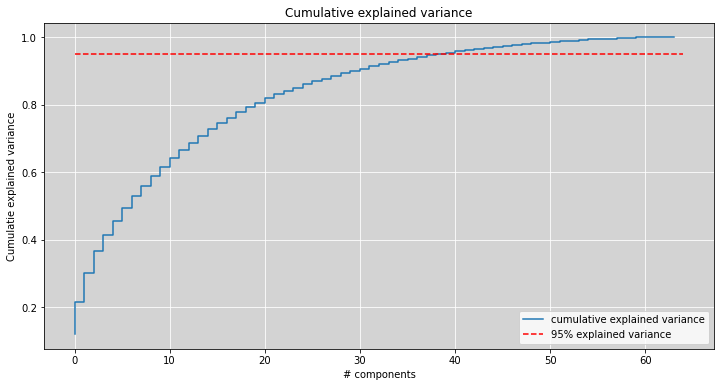

In [4]:
### BEGIN SOLUTION (do not delete this comment!)
  
from sklearn.decomposition import PCA
pca = PCA().fit(data)

plt.figure(figsize=(12, 6))

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.step(range(64), explained_variance, label='cumulative explained variance')
plt.title('Cumulative explained variance')
plt.xlabel('# components')
plt.ylabel('Cumulatie explained variance')
plt.grid(color='white')

plt.hlines(y=0.95, xmin=0, xmax=len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')
ax = plt.gca()
ax.set_facecolor('lightgrey')

plt.legend(loc='lower right')
plt.show()
### END SOLUTION (do not delete this comment!)

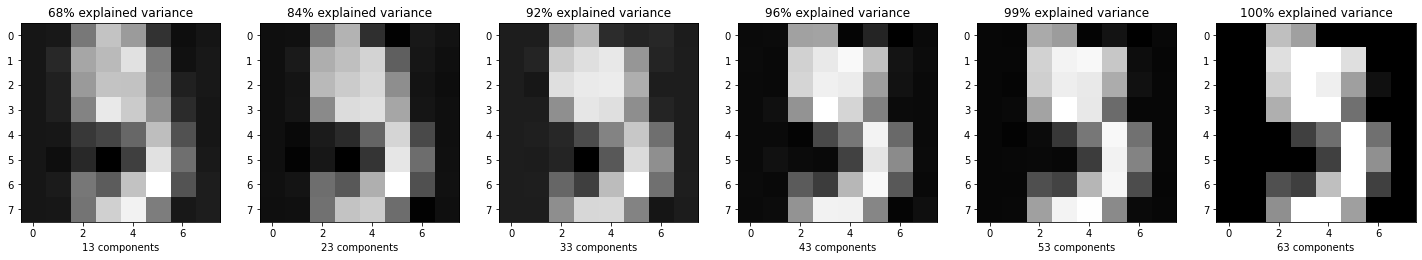

In [5]:
### BEGIN SOLUTION (do not delete this comment!)
fig, axis = plt.subplots(1, 6, figsize = [25, 120])

for i in range(13, 64, 10):
    pca = PCA(i).fit(data)
    data_reduced = pca.transform(data[5:6])
    data_recovered = pca.inverse_transform(data_reduced)
    axis[int(i / 10) - 1].imshow(scaler.inverse_transform(data_recovered).reshape(8,8), cmap='gray')  # Added SCALLER to show better

    title_components = str(i) + ' components'
    title_variance = str(int(explained_variance[i] * 100)) + '% explained variance'
    
    axis[int(i / 10) - 1].set_title(title_variance)
    axis[int(i / 10) - 1].set(xlabel=title_components)

plt.show()
### END SOLUTION (do not delete this comment!)

### Task 1.2. (1 pt.)

Here we will visualize the decomposition in order to observe how data diverges across different manifold learning methods. We are to compare `PCA`, `ICA` and `Isomap` non-linear decompositions [see more over here https://scikit-learn.org/stable/modules/manifold.html], and check the classification accuracy on the new features. 

1. Calculate new features on the data with ICA, PCA and Isomap. **Choose the number of components according to your estimation of intrinsic dimension**. Calculate the classification accuracy on these features with `LogisticRegression` on `cross_val=5` with $3$ repeats. Use `RepeatedKFold` and fit the `random_seed = 42`.
2. Show that the `Isomap` gives a statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. Justify your results, write down 2-3 sentences.


In [6]:
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind

1) Calculate new features on the data with ICA, PCA and Isomap. Choose the number of components according to your estimation of intrinsic dimention. Calculate the classification accuracy on these features with LogisticRegression on cross_val=5 with  3  repeats. Use RepeatedKFold and fit the random_seed = 42.

In [7]:
### BEGIN SOLUTION (do not delete this comment!)
targets = dg.target

random_seed = 42

comps = 8 # best param according to the intrinsic values 

data_ica = FastICA(n_components=comps).fit_transform(data)
data_pca = PCA(n_components=comps).fit_transform(data)
data_iso = Isomap(n_components=comps).fit_transform(data)


fold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_seed)

log_reg = LogisticRegression()

sc_pca = np.mean(cross_val_score(log_reg, data_pca, targets, cv=fold, scoring='accuracy'))
fold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_seed)
sc_ica = np.mean(cross_val_score(log_reg, data_ica, targets, cv=fold, scoring='accuracy'))
fold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_seed)
sc_iso = np.mean(cross_val_score(log_reg, data_iso, targets, cv=fold, scoring='accuracy'))
fold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=random_seed)

print("PCA score: ", sc_pca)
print("ICA score: ", sc_ica)
print("ISO score: ", sc_iso)

### END SOLUTION (do not delete this comment!)

PCA score:  0.8720081502114928
ICA score:  0.7150943980191891
ISO score:  0.9530625193438564


2) Show that the `Isomap` gives statistically significant improvement on the classification accuracy with any appropriate statistical test. Provide corresponding `p-values`. 

In [8]:
### BEGIN SOLUTION (do not delete this comment!)

# Let's compare the accuracies and use t-test for mu of groups.

print("Pvalues for models:")

fold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
print("H_0: PCA = ISO, p-value = ", ttest_ind(
    cross_val_score(log_reg, data_pca, targets, cv=fold, scoring='accuracy'),
    cross_val_score(log_reg, data_iso, targets, cv=fold, scoring='accuracy')
).pvalue)
fold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
print("H_0: ICA = ISO, p-value = ", ttest_ind(
    cross_val_score(log_reg, data_ica, targets, cv=fold, scoring='accuracy'),
    cross_val_score(log_reg, data_iso, targets, cv=fold, scoring='accuracy')
).pvalue)

### END SOLUTION (do not delete this comment!)

Pvalues for models:
H_0: PCA = ISO, p-value =  4.884067060842859e-13
H_0: ICA = ISO, p-value =  1.4982673421427805e-19


3) Justify your results, write down 2-3 senteces.

*BEGIN SOLUTION (do not delete this comment!)*

From scores we can see that Isomap perfroms better than PCA and ICA. Also we can reject both 0-hyposesis because p-value is very small for any any sensible significance level 

*END SOLUTION (do not delete this comment!)*

### Task 1.3. kMNIST dimensionality reduction. (2 pts.)

Explore `KMNIST` dataset https://github.com/rois-codh/kmnist. You are to engineer new features (by using any familiar to you method of Manifold Learning) to increase the classification accuracy. Use the `KNN` classifier with any hyperparameters you like.

1. __(2 pt.)__ Get accuracy on `test_set` more than 93%`. 

**NOTE** that the data is rather heavy, thus your decomposition will take a while.

__Hint:__ Try to use dimensionality reduction methods, which yield better model performance on `MNIST`. These methods can compete with Autoencoders on `torch`. 

1) Get accuracy on test_set more than 93%.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

def load(f):
    return np.load(f)['arr_0']

# Load the data
x_train = load('kmnist-train-imgs.npz')
x_test = load('kmnist-test-imgs.npz')
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

# Reshape the data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

In [10]:
### BEGIN SOLUTION (do not delete this comment!)
pca = PCA(n_components=80).fit(x_train)
print("AASAS")
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print("AASAS")
#clf = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
print("AASAS")
#clf.fit(x_train_pca, y_train)
print("AASAS")
#score = clf.score(x_test_pca, y_test)
print("AASAS")

#print('Score for MNIST dataset with 10 comp reduction in PCA - ' + str(score))

### END SOLUTION (do not delete this comment!)

AASAS
AASAS
AASAS
AASAS
AASAS


In [11]:
clf = KNeighborsClassifier(n_jobs=-1)

In [12]:
y_train.shape

(60000,)

In [13]:
clf.fit(x_train_pca, y_train)

KNeighborsClassifier(n_jobs=-1)

In [ ]:
score = clf.score(x_test_pca, y_test)

In [ ]:
x_test_pca

## Task 2 - Clustering (2 pts.)

### Task 2.1. Explore KMeans and Gaussian Mixture algorithms (1 pt.)

Try **KMeans, Gaussian Mixture** and **two** more clustering algorithms from sklearn. 
To evaluate clustering performance use **two** clustering metrics: *silhouette score*
and *mutual information* or *adjusted mutual information*.

For each algorithm **your task** is to try to find the parameters leading to the best performance for `n_clusters=true_number_of_clusters`:
1. Apply the algorithm with the true number of clusters and try out at least two **other variants** of the number of clusters: a smaller and a larger one than the true number.;
2. For each number of clusters **visualize the clustering result**, calculate the **clustering metrics** and plot them;

__NOTE:__ `sklearn.model_selection.GridSearchCV` does not support clustering methods, thus you suppose to do it manually.

In [ ]:
import numpy as np

In [ ]:
points, labels = np.loadtxt('clustering.txt'), np.loadtxt('clustering_labels.txt')
labels = labels.astype(int)
print("True number of clusters is {}".format(np.max(labels)))
plt.figure(figsize=(10, 10))
plt.scatter(points[:,0], points[:,1], c=labels, alpha=0.3, edgecolor='k')

plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, mutual_info_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

1) For each algorithm your task is to try to find the parameters leading to the best performance for n_clusters=true_number_of_clusters

In [ ]:
## BEGIN SOLUTION (do not delete this comment!)
from sklearn import metrics
from itertools import product
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
    

grid_kmeans = {
    #'n_clusters': [15],
    'n_init': np.arange(10, 60, 10),
    'max_iter': np.arange(50, 250, 50)
}

grid_gaussian = {
    #'n_components': [15],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'max_iter': np.arange(50, 250, 50)
}

grid_spec = {
    #'n_clusters': [15],
    'eigen_solver': ['arpack', 'lobpcg'],
    'affinity': ['nearest_neighbors', 'rbf'],
    'degree': np.arange(2, 5, 1)
}

grid_aggl = {
    #'n_clusters': [15],
    'linkage': ["complete", "average", "single"],
    'affinity': ["euclidean", "l1", "l2"]
}


list_of_grids = [grid_kmeans, grid_gaussian, grid_spec, grid_aggl]

list_of_models = [KMeans, GaussianMixture, SpectralClustering, AgglomerativeClustering]
list_of_names = ["KMeans", "Gaussian", "Spectral", "Agglomerative"]

list_of_scores = [silhouette_score, mutual_info_score]
list_scores_names = ["silhouette", "mutual info"]


def make_grid(params):  
    keys=params.keys()
    combinations=product(*params.values())
    return [dict(zip(keys,c)) for c in combinations]

def best_params(model, args, score, data, labels):
    grid = make_grid(args)
    scores = list(score(labels, model(**p).fit_predict(data)) for p in grid)
        
    return np.max(scores), grid[np.argmax(scores)]


results = []


for i in range(4):
    
    res_model = []
    grid = make_grid(list_of_grids[i])
    
    scores_silhouette = list(silhouette_score(points, list_of_models[i](15, **p).fit_predict(points)) for p in grid)
    scores_mutual = list(mutual_info_score(labels, list_of_models[i](15, **p).fit_predict(points)) for p in grid)
    res_model.append((np.max(scores_silhouette), grid[np.argmax(scores_silhouette)]))
    res_model.append((np.max(scores_mutual), grid[np.argmax(scores_mutual)]))
    
    results.append(res_model)

    
fig, ax = plt.subplots(4, 2, figsize=(20, 40))


for i in range(4):
    for j in range(2):
        label = list_of_models[i](15, **results[i][j][1]).fit_predict(points)
        ax[i, j].scatter(points[:,0], points[:,1], c=label, alpha=0.3, edgecolor='k')
        title = list_of_names[i] + ' : ' + list_scores_names[j] + ' score = ' + str(np.round(results[i][j][0], 4)) 
        ax[i, j].set_title(title, pad=15)
        ax[i, j].set_xticks([])
plt.show()

### END SOLUTION (do not delete this comment!)

2) Apply the algorithm with the true number of clusters and try out at least two other variants of the number of clusters: a smaller and a larger one than the true number.;

 Do not forget that despite the plot picturing just the KMeans and GuassianMizture, you will need to ADDITIONALLY try put and plot two other clustering methods. 

In [ ]:
## BEGIN SOLUTION (do not delete this comment!)

best_params = results

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

cl = np.array([5, 10, 15, 20])

for i in range(4):
    for j in range(4):
        label = list_of_models[i](cl[j], **results[i][0][1]).fit_predict(points)
        ax[i, j].scatter(points[:,0], points[:,1], c=label, alpha=0.3, edgecolor='k')
        ax[i, j].set_title(list_of_names[i] + ', ' + 'clusters = ' + str(cl[j]))

### END SOLUTION (do not delete this comment!)

3) For each number of clusters vizualize the clustering result, calculate the clustering metrics and plot them;


In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

cl = np.array([5, 10, 15, 20])

for i in range(4):
    scores_silh, scores_mut = [], []
    for j in range(4):
            
        label_silh = list_of_models[i](cl[j], **results[i][0][1]).fit_predict(points)
        label_mut = list_of_models[i](cl[j], **results[i][1][1]).fit_predict(points)
        
        scores_silh.append(list_of_scores[0](points, label_silh))
        scores_mut.append(list_of_scores[1](labels, label_mut))
    
    ax[i].set_title(list_of_names[i], pad=10)
    ax[i].plot(cl, scores_silh, c='green', marker='x', label='silhouette')
    ax[i].plot(cl, scores_mut, c='blue', marker='x', label='mutual inf')
    ax[i].legend(loc='right')
    ax[i].set_xticks(cl)
    ax[i].set_xlabel('n_clusters')
    
### END SOLUTION (do not delete this comment!)

### Task 2.2. Finding the Number of Clusters with Bootstrap. (1 pt.)
For a chosen algorithm find the best number of clusters using bootstrap. Based on your observations made at the previous task, choose one algorithm assuming **you do not have true labels and do not know the true number of clusters**.
1. Estimate variance of the clustering metric of your choice (i.e. *silhouette score*/*mutual information*/*adjusted mutual information*)and construct normal 95% **confidence interval (CI)**;
2. **Plot the metric** with the corresponding confidence intervals and show the best number of clusters.

__Hints:__ 
- you can choose bootstrap samples with any size, and sample number starting from `50`;
- you can use `scipy.stats.norm.interval()` to derive CI;

1) Estimate variance of the clustering metric of your choice (i.e. silhouette score/mutual information/adjusted mutual information)and construct normal 95% confidence interval (CI);

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)
from scipy.stats import norm

cl = np.arange(5, 21)
n_iters = 100
samp_size = 500

metric = []

for n_cl in tqdm(cl):
    silhouette = []
    for iter in range(n_iters):
        X = points[rng.randint(0, points.shape[0], size=samp_size)]
        km = KMeans(n_clusters=n_cl, random_state=42).fit_predict(X)
        silhouette.append(silhouette_score(X, km))
    metric.append(silhouette)

metric = np.array(metric)
mean = metric.mean(axis=1)
var = metric.var(axis=1)


### END SOLUTION (do not delete this comment!)


2) Plot the metric with the corresponding confidence intervals and show the best number of clusters.

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

ci = 0.95

intervals = []

for i, n_clusters in enumerate(cl):
    interval = norm.interval(ci, mean[i], np.sqrt(var[i]))
    intervals.append(interval)
    
intervals = np.array(intervals)

fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(7)

plt.plot(cl, mean, c='red', label='Mean')
plt.fill_between(cl, intervals[:, 0], intervals[:, 1], alpha=0.2, label='CI=0.95')
plt.vlines(15, 0.45, 0.66, linestyles='--')
plt.xlabel('n clusters')
plt.ylabel('silhouette score')
plt.xlim(6,20)
plt.show()
### END SOLUTION (do not delete this comment!)

## Task 3. Practice with Different Anomaly Detection Algorithms. (2 pts)

### Task 3.1 (1 pt)

- Here we will use __fraud_dataset__ (creditcard.csv )
- Compute the __contamination__ (or impurity) on the **test** set as the ratio of anomaly objects to all the objects.  
- Predict the anomaly with any **three** Anomaly detection methods among ones from: https://scikit-learn.org/stable/modules/outlier_detection.html, note, we do not use true labels to fit anomaly detectors.
- Explore, how the `roc_auc_score` for anomaly detectors changes with `contamination` value, taking a grid `[0.1*contamination, 1*contamination, 10*contamination]`. Point out the best performing algorithm.

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score

data = pd.read_csv('./creditcard.csv')

X = data.drop(columns="Class")
y = data["Class"]

# keep the split fixed
tt_split = train_test_split(X, y, test_size = 0.1, stratify=y, random_state= 42)
train_X, test_X, train_y, test_y = tt_split 

# delete the targets for training
train_y = 0

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)
  
# impurity estimation on test data

contamination = test_y.value_counts()[1] / test_y.shape[0]

### END SOLUTION (do not delete this comment!)

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
algs = ["IsolationForest", "LocalOutlierFactor", "EllipticEnvelope"]

random_state = 42

transf = lambda x: (1 - x) / 2

for i in [0.1, 1, 10]:
    


    y_isolation = transf(IsolationForest(contamination=contamination*i).fit_predict(np.array(test_X)))
    y_local = transf(LocalOutlierFactor(contamination=contamination*i).fit_predict(np.array(test_X)))
    y_elliptic = transf(EllipticEnvelope(contamination=contamination*i).fit_predict(np.array(test_X)))

    print('IsolationForest: ',
          'Contamination: ', np.round(contamination * i, 3), ' ', 
          'ROC/AUC: ', np.round(roc_auc_score(test_y, y_isolation), 3),
          'Precision: ', np.round(precision_score(test_y, y_isolation, average = 'micro'), 3))
    print('\n')
    print('LocalOutlierFactor: ',
          'Contamination: ', np.round(contamination * i, 3), ' ', 
          'ROC/AUC: ', np.round(roc_auc_score(test_y, y_local), 3),
          'Precision: ', np.round(precision_score(test_y, y_local, average = 'micro'), 3))
    print('\n')
    print('EllipticEnvelope: ',
          'Contamination: ', np.round(contamination * i, 3), ' ', 
          'ROC/AUC: ', np.round(roc_auc_score(test_y, y_elliptic), 3),
          'Precision: ', np.round(precision_score(test_y, y_elliptic, average = 'micro'), 3))
    print("_____________________________________________________________________________________________________________")
    
### END SOLUTION (do not delete this comment!)

We will choose on IsolationForest with contamination = 0.169

### Task 3.2 (1 pt)

The idea is to see when anomaly detection methods, trained with no labels, can facilitate the prediction of the classifier. Imagine a real case scenario: you have labelled only a small portion of the dataset and a bunch of unlabeled data. We will simulate the situation when __90%__ of data is unlabeled and we still desire to achieve good performance. 


As you can score your predictions only on the __10%__ of the sample, you better do it in cross validation to ensure the model stability.
1. Take your favorite classifier and estimate the performance on __test set__ using `StratifiedKFold(n_splits=10, random_state = 42)` with `roc_auc` and `precision_score`. You can use test set upsampling and other instruments to enforce your prediction. 

> Do not get confused, here we swap __train__ and __test__ and use __test__ as if it's the only data we have on our hands.

2. Try to enhance the classifier performance in  `roc_auc` or `precision_score` (or ideally both), building the ensemble, using __Anomaly detection__ methods from the previous task. You can fit __Anomaly detection__ methods on both  __training set__ and subset from __test set__ on the cross-validation fold. Write 1-2 sentences on your findings.

__NOTE:__ try not to overfit, thus not adjust the `contamination` while training, and refit classifiers on each fold. 

__Hints:__ `sklearn.ensemble.VotingClassifier` does not support Anomaly detection methods, so you are to write it yourself. And `np.logical_and` or `np.logical_or` will suit for the trivial ensemble.

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)

# your favorite classifier

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=10, random_state = 42, shuffle=True)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = []
pr_score = []
recall = []

for train_index, test_index in skf.split(test_X, test_y):
    rf = RandomForestClassifier(random_state=random_state).fit(test_X.iloc[train_index], test_y.iloc[train_index])
    predicted = rf.predict(test_X.iloc[test_index])
        
    roc_auc_scores.append(roc_auc_score(test_y.iloc[test_index].values, predicted))
    recall.append(recall_score(test_y.iloc[test_index], predicted.astype(int)))
    pr_score.append(precision_score(test_y.iloc[test_index].values, predicted))
    
    
### END SOLUTION (do not delete this comment!)

print('ROC/AUC mean: ', np.mean(roc_auc_scores), 'std: ', np.std(roc_auc_scores))    
print('Precision mean: ', np.mean(pr_score), 'std: ', np.std(pr_score))
print('Recall mean: ', np.mean(recall), 'std: ', np.std(recall))

In [ ]:
### BEGIN SOLUTION (do not delete this comment!)
from sklearn.metrics import recall_score


skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(test_X, test_y)

roc_auc_scores = []
pr_score = []
recall = []

for train_index, test_index in skf.split(test_X, test_y):
    ifr  = IsolationForest(contamination=contamination*10, random_state=random_state)
    ifr_predict = ifr.fit(train_X).predict(test_X.iloc[test_index])
    ifr_predict = (-(ifr_predict - 1) / 2).astype(int)
    lr = RandomForestClassifier(random_state=random_state)
    lr_predict = lr.fit(test_X.iloc[train_index], test_y.iloc[train_index]).predict(test_X.iloc[test_index])
    predict = np.logical_or(ifr_predict, lr_predict)
    roc_auc_scores.append(roc_auc_score(test_y.iloc[test_index], predict.astype(int)))
    recall.append(recall_score(test_y.iloc[test_index], predict.astype(int)))
    pr_score.append(precision_score(test_y.iloc[test_index], predict.astype(int)))
    
    
### END SOLUTION (do not delete this comment!)
    
print('ROC/AUC mean: ', np.mean(roc_auc_scores), 'std: ', np.std(roc_auc_scores))    
print('Precision mean: ', np.mean(pr_score), 'std: ', np.std(pr_score))
print('Recall mean: ', np.mean(recall), 'std: ', np.std(recall))

To boost precision we need choose **logical_and**

But in this particular task we probably need higher Recall - because it's a fraud detection. If we choose **logical_and** we will drive precision up, because model will call transaction fradulent only if classificator and anomaly detection called together. So its probably better to choose **logical_or**, but heavily depends on terms
